# Predicting Disputes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_csv("C:/Users/kurtl/Downloads/complaints-2022-04-06_13_44.csv")

In [4]:
# Drop rows with NaN in 'Consumer Disputed?'
df = df.dropna(subset=["Consumer disputed?"])

In [5]:
# Choose features
X = df[['Tags','Consumer consent provided?', 'Submitted via', 'Company response to consumer', 
        'Timely response?', 'Consumer disputed?']]
X.head()

,Tags,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
1,None,NaN,Referral,Closed with explanation,Yes,No
6,None,NaN,Referral,Closed with explanation,Yes,No
7,None,Consent provided,Web,Closed with explanation,Yes,No
27,None,Consent provided,Web,Closed with explanation,Yes,No
32,None,Consent provided,Web,Closed with explanation,Yes,No


In [6]:
# Create dictionaries for mapping categorical variables
tag_map = {'Servicemember': 1, 'None': 2, 'Older American': 3,
       'Older American, Servicemember': 4}
consumer_map = {'Consent provided': 1, 'Consent not provided': 2, 'Other': 3, 'None': 4}
sub_map = {'Web': 1, 'Referral': 2, 'Postal mail': 3, 'Phone': 4, 'Fax': 5, 'Email': 6}
response_map = {'Closed with non-monetary relief':1, 'Closed with explanation':2,
       'Closed with monetary relief':3, 'Closed':4, 'Closed without relief':5,
       'Closed with relief':6, 'Untimely response':7}
time_map = {'Yes': 1, 'No': 0}

In [7]:
# Map categorical variables in df
X['Tags'] = X['Tags'].map(tag_map)
X['Consumer consent provided?'] = X['Consumer consent provided?'].map(consumer_map)
X['Submitted via'] = X['Submitted via'].map(sub_map)
X['Timely response?'] = X['Timely response?'].map(time_map)
X['Company response to consumer'] = X['Company response to consumer'].map(response_map)
X.head()

C:\Users\kurtl\AppData\Local\Temp\ipykernel_16616\54095789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Tags'] = X['Tags'].map(tag_map)
C:\Users\kurtl\AppData\Local\Temp\ipykernel_16616\54095789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Consumer consent provided?'] = X['Consumer consent provided?'].map(consumer_map)
C:\Users\kurtl\AppData\Local\Temp\ipykernel_16616\54095789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,Tags,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Consumer disputed?
1,2,NaN,2,2,1,No
6,2,NaN,2,2,1,No
7,2,1.0,1,2,1,No
27,2,1.0,1,2,1,No
32,2,1.0,1,2,1,No


In [8]:
# Drop any rows with blanks from final df
X = X.dropna()

In [9]:
# Create 1d-array with target variable
y = np.where(X['Consumer disputed?'] == 'Yes', 1, -1)
y

array([-1, -1, -1, ..., -1, -1, -1])

In [10]:
# Convert X to NumPy array called X2
X2 = X.iloc[:,:-1].values
X2

array([[2., 1., 1., 2., 1.],
       [2., 1., 1., 2., 1.],
       [2., 1., 1., 2., 1.],
       ...,
       [3., 3., 1., 2., 1.],
       [2., 1., 1., 2., 1.],
       [2., 1., 1., 2., 1.]])

In [11]:
class Perceptron(object):
    '''
    Perceptron classifier.
    Parameters
    ------------
    eta : float
        learning rate (between 0.0 and 1.0)
    n_iter: int 
        Pass over the training dataset 
    random_state: int
        Random number generator weight for random weights 
        
    Attributes
    ----------
    w_: 1d-array
        weights after fitting 
    cost_: list
        Number of missclassification (updates) on each epoch
    '''
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        
        for _ in range(self.n_iter):
            error = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update # bias term
                error += int(update != 0.0)
            self.cost_.append(error)
        return self
            
    def net_output(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return np.where(self.net_output(X) >= 0.0, 1, -1)

In [12]:
# Run the algorithm
ppn = Perceptron(n_iter=10, eta=0.01).fit(X2, y)

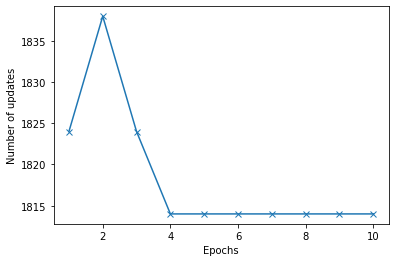

In [13]:
# Visualize the accuracy
plt.plot(range(1, len(ppn.cost_) + 1), ppn.cost_, marker='x')
plt.xlabel('Epochs')
plt.ylabel('Number of updates');

In [14]:
class AdalineGD(object):
    '''
    Parameters:
    eta : float
        learning rate
    n_iter : int
        number of epochs
    random_state : int
        random initial weights generator
    
    Attributes:
    w_ : 1d-array
        weights after fitting
    cost_ : list
        misclassifications in each epoch
    '''
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_output = self.net_output(X)
            output = self.activation(net_output)
            errors = y - output # column of errors
            self.w_[1:] += self.eta * X.T.dot(errors) # sum of weights
            self.w_[0] += (self.eta * errors).sum() # bias term
            cost = (errors ** 2).sum()
            self.cost_.append(cost)
        return self 
    
    def net_output(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X): # linear activation function, something more complicated
        return X
    
    def predict(self, X): # apply step function at the end with activation embedded
        return np.where(self.activation(self.net_output(X)) >= 0, 1, -1)

In [15]:
# Run the algorithm
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X2, y)

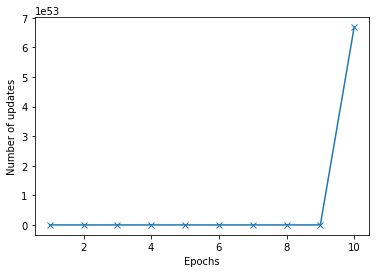

In [16]:
# Visualize the accuracy
plt.plot(range(1, len(ada1.cost_) + 1), ada1.cost_, marker='x')
plt.xlabel('Epochs')
plt.ylabel('Number of updates');